# Milestone 2
Supervised learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import sklearn
import sklearn.preprocessing
import sklearn.metrics
import seaborn as sns; sns.set()

from sklearn import neighbors, linear_model, svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint

## Load data

In [2]:
df = pd.read_csv('dengue_features_train.csv')
y_ = pd.read_csv('dengue_labels_train.csv')

In [3]:
df['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [4]:
df.drop(['week_start_date'], axis=1, inplace=True)
df.set_index(['city', 'year', 'weekofyear'], inplace=True)
y_.set_index(['city', 'year', 'weekofyear'], inplace=True)
df.shape, y_.shape

((1456, 20), (1456, 1))

In [5]:
df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                           
sj   1990 18          0.122600  0.103725  0.198483  0.177617   
          19          0.169900  0.142175  0.162357  0.155486   
          20          0.032250  0.172967  0.157200  0.170843   
          21          0.128633  0.245067  0.227557  0.235886   
          22          0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
city year weekofyear                                                         
sj   1990 18                              299.8                      295.9   
          19                              300.9                      296.4   
          20                              300.5                      297.3   
          21                              301.4                      297.0   
          22                              301.9                      297.5   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571

In [6]:
df.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


# Preprocessing

## Fill NaN

In [7]:
df.isna().sum()
# ffill: propagate last valid observation forward to next valid backfill
# @ Check other methods
df.fillna(method="bfill", inplace=True)
df.isna().sum()

ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int64

## Normalize data

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
#scaler = sklearn.preprocessing.MinMaxScaler()
X_ = scaler.fit_transform(df)

## PCA
Normalize the data and apply find best principal components.

In [9]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_)
X_pca.shape

(1456, 20)

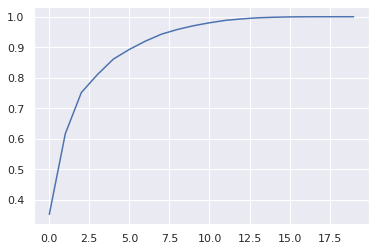

In [10]:
var_ratio = pca.explained_variance_ratio_
plt.plot(np.arange(len(var_ratio)), np.cumsum(var_ratio))

In [11]:
X_pca = pd.DataFrame(X_pca, index=df.index)

In [12]:
X_pca

0         1         2         3         4  \
city year weekofyear                                                     
sj   1990 18         -2.714511  3.320614  0.142617 -0.257409  0.456776   
          19         -1.931005  1.074159 -0.204686 -0.231752 -0.219148   
          20         -1.520876 -0.404612  0.420638 -0.419656 -0.301553   
          21         -0.737826 -0.322634 -1.127042 -1.369559 -0.234293   
          22          0.418916 -1.234790 -2.177662 -1.336974 -0.619055   
...                        ...       ...       ...       ...       ...   
iq   2010 21          4.341231 -1.184247 -1.724764 -0.064022 -0.498205   
          22          3.359854 -0.817543  1.927258  1.079591 -1.763563   
          23          1.424569  2.719413  1.686489 -0.556499 -0.638215   
          24          2.588220  2.712221  1.306983 -1.484605 -0.497854   
          25          3.457524  0.513618 -0.769946 -0.229732  0.010156   

                             5         6         7         8         9  \
city year weekofyear                                                     
sj   1990 18         -0.280418  0.151802  0.800533  0.072159  0.247708   
          19         -0.300118 -0.933091  0.626800  0.167575 -0.136430   
          20          0.219749 -0.602001  0.066011 -0.056156  0.445813   
          21         -0.264416 -0.894852  0.146368  0.310056  0.249201   
          22         -0.173099 -1.144737  0.191980  1.003958  0.633800   
...                        ...       ...       ...       ...       ...   
iq   2010 21         -0.357380 -0.220516  0.088153 -0.601004  0.126450   
          22         -1.224704  2.111325  1.210757  0.390485 -0.411908   
          23         -0.873711  0.484817 -1.113666 -1.552115 -0.186731   
          24         -0.829854  0.053619 -0.664274 -0.965801 -0.815066   
          25         -0.491930 -0.039893 -0.593646 -0.546682 -0.924396   

                            10        11        12        13        14  \
city year weekofyear                                                     
sj   1990 18          0.205244 -0.056535 -0.281517  0.225705 -0.183667   
          19          0.089682  0.035726  0.246228  0.120080 -0.157287   
          20         -0.647440 -0.128568  0.369457 -0.173412  0.135799   
          21         -0.595545 -0.215810  0.506784 -0.063631  0.086111   
          22         -0.150956 -0.291938 -0.058463 -0.280019  0.199316   
...                        ...       ...       ...       ...       ...   
iq   2010 21         -0.050577  0.136870 -0.132456 -0.409451 -0.123502   
          22         -0.427172  0.475013  0.324071 -0.036092  0.290369   
          23          0.524476  0.156666  1.381329  0.170317 -0.163728   
          24         -0.069628  0.387048  0.191924 -0.319051 -0.084924   
          25         -0.196593  0.277374  0.098769 -0.127088  0.213781   

                            15        16        17        18            19  
city year weekofyear                                                        
sj   1990 18         -0.103277 -0.013733  0.066961  0.019258  1.060934e-16  
          19         -0.033781 -0.080543 -0.000746 -0.014340  3.041506e-16  
          20         -0.118134  0.058123 -0.020310  0.014927  4.860905e-17  
          21         -0.037738 -0.080307 -0.040636 -0.008353 -1.490354e-16  
          22         -0.002818  0.021804 -0.026813 -0.013195  1.049894e-14  
...                        ...       ...       ...       ...           ...  
iq   2010 21          0.150513 -0.027511  0.002086  0.035183 -1.581014e-17  
          22          0.594716 -0.250824 -0.065674  0.030549  7.947030e-18  
          23         -0.019437  0.133457 -0.048710  0.029869  5.952101e-17  
          24          0.223246  0.047831 -0.052294 -0.003486  3.328509e-17  
          25         -0.221474 -0.101708 -0.021686 -0.017986  1.087227e-17  

[1456 rows x 20 columns]

## Prepare work sets

In [13]:
GROUP_SUBSET = False

In [14]:
X_ = pd.DataFrame(X_, index=df.index, columns=df.columns)

In [15]:
if GROUP_SUBSET:
    sj = X_.loc['sj'][X_.loc['sj'].index.get_level_values(0) >= 1992]
    sj = sj[sj.index.get_level_values(0) <= 1998]
    X_.drop('sj', level=0, inplace=True)
    X_ = pd.concat((pd.concat({'sj':sj}), X_))

    sj = y_.loc['sj'][y_.loc['sj'].index.get_level_values(0) >= 1992]
    sj = sj[sj.index.get_level_values(0) <= 1998]
    y_.drop('sj', level=0, inplace=True)
    y_ = pd.concat((pd.concat({'sj':sj}), y_))

## Preprocess function
Define a function which allows repetition of the preprocessing steps taken.

In [16]:
def preprocess(df):
    df.drop(['week_start_date'], axis=1, inplace=True)
    df.set_index(['city', 'year', 'weekofyear'], inplace=True)
    
    df.fillna(method="bfill", inplace=True)
    scaler = sklearn.preprocessing.StandardScaler()
    x = scaler.fit_transform(df)
    x = pd.DataFrame(x, index=df.index, columns=df.columns)
    
    return x

# 0. Analyze data

In [17]:
X_analyze = X_.join(y_)
X_pca_analyze = X_pca.join(y_)

### Mean and variance

In [18]:
y_.mean(level=0)

,total_cases
city,
sj,34.180556
iq,7.565385


In [19]:
y_.var(level=0)

,total_cases
city,
sj,2640.045440
iq,115.895524


### Distribution

Text(0.5, 1.0, 'iq')

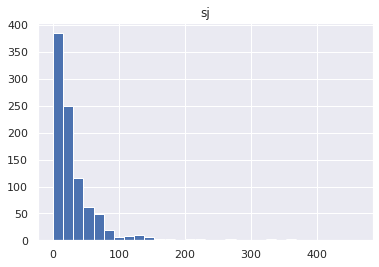

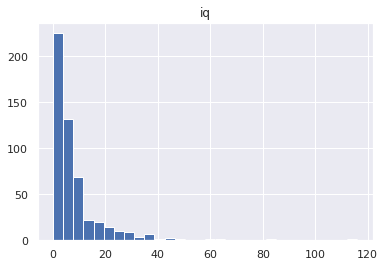

In [20]:
y_.loc['sj'].hist(bins=30)
plt.title('sj')
y_.loc['iq'].hist(bins=30)
plt.title('iq')

## 0.1. Target space transformation
The goal is to achieve normal distribution on the target state space.

In [93]:
class LogShift:
    ENABLED = True
    
    @staticmethod
    def normal(arr):
        return np.log(arr + 1)
    
    @staticmethod
    def original(arr):
        return np.rint(np.e ** arr - 1) if LogShift.ENABLED else arr

In [22]:
y_['normal'] = LogShift.normal(y_.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f205ae301c0>,
      dtype=object)

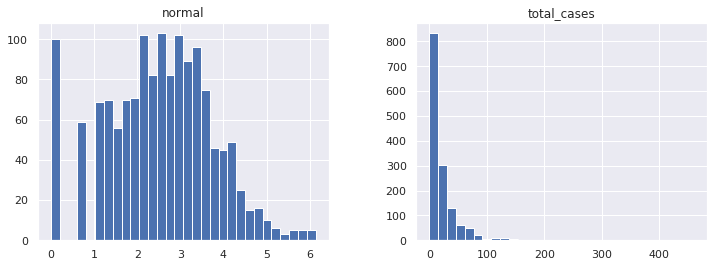

In [23]:
y_.hist(bins=30, figsize=(12,4))

## 0.2. Features importance

In [24]:
corr_X = X_analyze.corr()

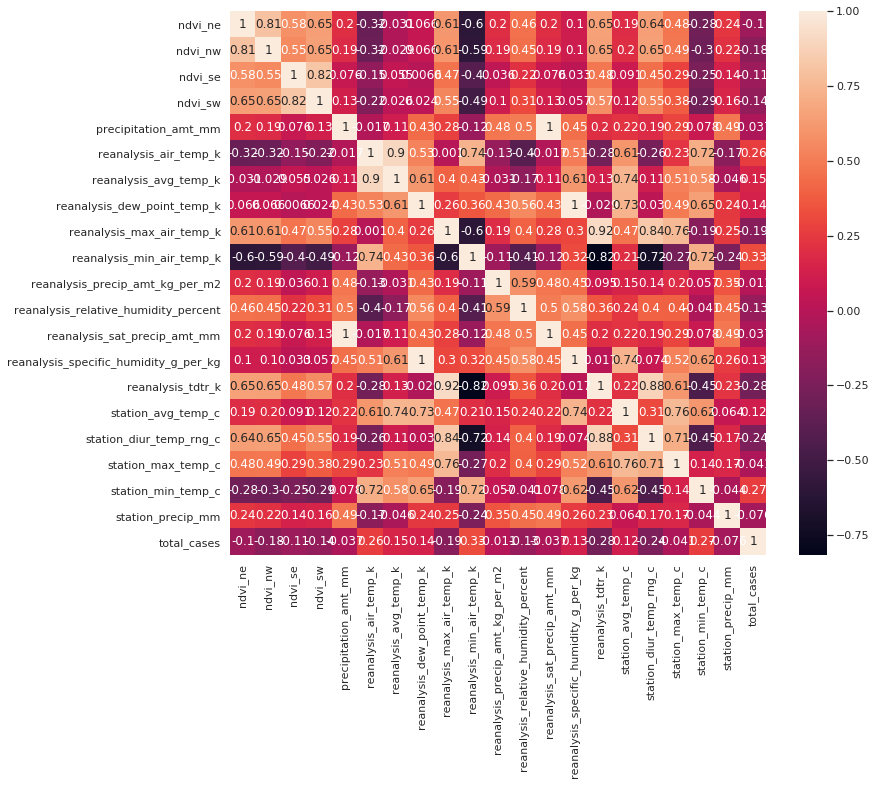

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_X, annot=True)

### 0.2.1. Find correlated features

In [26]:
threshold = 0.8

In [27]:
duplicates = corr_X.abs().values > threshold
duplicate_count = pd.DataFrame(duplicates.sum(axis=0) - 1, index=corr_X.index, columns=['duplicates'])

duplicates = np.argwhere(duplicates)
duplicates = duplicates[(lambda x: x[0] != x[1])(duplicates.T)]
duplicates.sort()

duplicates = np.vectorize(lambda x: corr_X.columns[x])(duplicates)

In [28]:
duplicates = set([tuple(elem) for elem in duplicates])
duplicates

{('ndvi_ne', 'ndvi_nw'),
 ('ndvi_se', 'ndvi_sw'),
 ('precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm'),
 ('reanalysis_air_temp_k', 'reanalysis_avg_temp_k'),
 ('reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg'),
 ('reanalysis_max_air_temp_k', 'reanalysis_tdtr_k'),
 ('reanalysis_max_air_temp_k', 'station_diur_temp_rng_c'),
 ('reanalysis_min_air_temp_k', 'reanalysis_tdtr_k'),
 ('reanalysis_tdtr_k', 'station_diur_temp_rng_c')}

### 0.2.2. Feature importances

0.1486834166525061

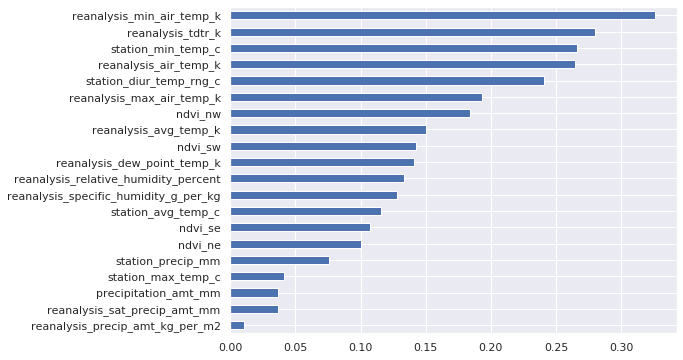

In [29]:
plt.figure(figsize=(8,6))
feature_importance_X = corr_X['total_cases'].drop('total_cases').abs().sort_values()
feature_importance_X.plot.barh()
feature_importance_X.mean()

### 0.2.3. Clean duplicates with less importance

In [30]:
needs_cleaning = []
for a,b in duplicates:
    bias = feature_importance_X[a] - feature_importance_X[b]
    needs_cleaning.append(b if bias > 0 else a)

In [31]:
needs_cleaning

['reanalysis_avg_temp_k',
 'ndvi_se',
 'reanalysis_specific_humidity_g_per_kg',
 'station_diur_temp_rng_c',
 'precipitation_amt_mm',
 'reanalysis_max_air_temp_k',
 'reanalysis_max_air_temp_k',
 'ndvi_ne',
 'reanalysis_tdtr_k']

In [32]:
X_.drop(needs_cleaning, axis=1, inplace=True)

0.18719241299580933

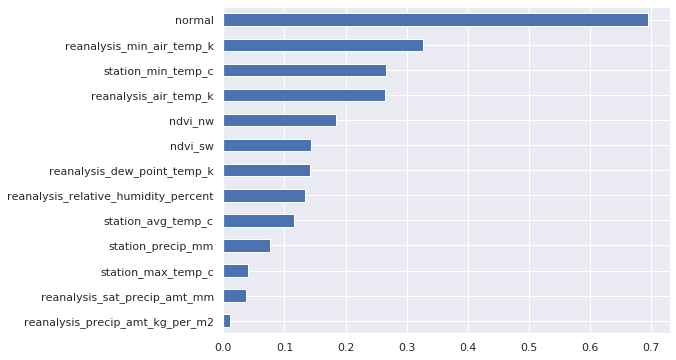

In [33]:
plt.figure(figsize=(8,6))
feature_importance_X = X_.join(y_).corr()['total_cases'].drop('total_cases').abs().sort_values()
feature_importance_X.plot.barh()
feature_importance_X.mean()

## 0.3. PCA components importance

In [34]:
corr_pca = X_pca_analyze.corr()

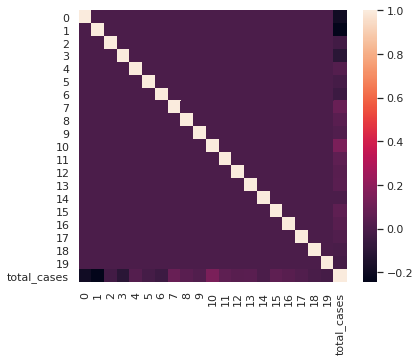

In [35]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_pca, annot=False)

0.06194929622698806

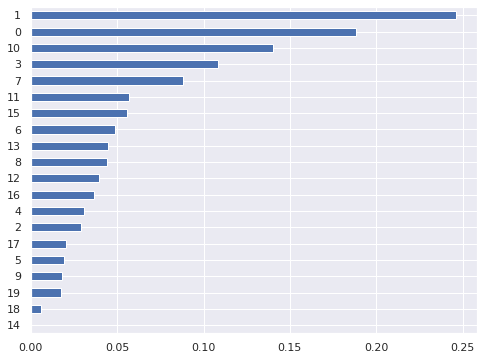

In [36]:
plt.figure(figsize=(8,6))
feature_importance_pca = corr_pca['total_cases'].drop('total_cases').abs().sort_values()
feature_importance_pca.plot.barh()
feature_importance_pca.mean()

# 1. Baseline

### Helper functions

In [37]:
def split_to_train(X, y, test_size=0.1):
      return train_test_split(pd.concat([X, y], axis=1), test_size=test_size)
    
def get_predictions(regressor, X):
    return np.rint(regressor.predict(X))

def get_mae(regressor, X, y):
    y_pred = get_predictions(regressor, X)
    return mean_absolute_error(y_pred, y)

def fit_regressor(regressor, X, y):
    train, test = split_to_train(X, y)
    regressor.fit(X=train.drop(['total_cases'], axis=1), y=train['total_cases'])
    
    return get_mae(regressor, test.drop(['total_cases'], axis=1), test['total_cases'])

def generate_visualization(y_pred, y):
    mae = mean_absolute_error(y, y_pred)

    plt.plot(np.arange(len(y_pred)), y, c='r', label='data')
    plt.plot(np.arange(len(y_pred)), y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()

    plt.show()
    return mae

def get_fold_accuracy(regressor, X, y, n_splits=10):
    fold_accuracy = []
    cv = KFold(n_splits, shuffle=False)
    for train_fold, test_fold in cv.split(X):
        X_train = X.iloc[train_fold]
        X_test = X.iloc[test_fold]
        y_train = y.iloc[train_fold]
        y_test = y.iloc[test_fold]

        regressor.fit(X=X_train, y=y_train.values.ravel())
        fold_accuracy.append(get_mae(regressor, X_test, y_test))
    return fold_accuracy

def get_accuracy(regressor, X, y, n_splits=10):
    fold_accuracy = get_fold_accuracy(regressor, X, y, n_splits)
    return max(fold_accuracy) #sum(fold_accuracy) / len(fold_accuracy)

def generate_plot(X, y, regressor, param_name, pm_range, n_split=10):
    mae = []
    for i in pm_range:
        regressor.set_params(**{param_name:i})
        mae.append(get_accuracy(regressor, X, y, n_split))

    label = type(regressor).__name__

    if type(regressor).__name__ == 'KNeighborsRegressor':
        label = regressor.get_params()['weights']
    elif type(regressor).__name__ == 'RandomForestRegressor':
        params = regressor.get_params()
        n_estimators = params['n_estimators']
        max_depth = params[param_name]
        label = f'n_estimators={n_estimators}'

    plt.plot(pm_range, mae, marker='o', label=label)
    print ('Min Value: {} ({})'.format(min(mae), list(pm_range)[np.argmin(mae)]))
    plt.xlabel(param_name)
    plt.ylabel('MAE')
    plt.legend()

def save_results(y_pred, name, index):
    res = np.rint(y_pred) # round
    res = res.astype(int) # cast to int
    aux = pd.DataFrame(np.vstack((*np.array(index.values.tolist()).T, res)).T, columns=list(index.names)+['total_cases'])
    aux.to_csv(name, index=False)
    return name

# 1.0. Select data to work on

## 1.1. Drop least important features

In [38]:
drop_features = 0
drop_features = list(feature_importance_X[:drop_features].index)
drop_features

[]

## 1.2. Set target dataset
Here we assign a work dataset.
It can be the whole dataset / Iquitos part / San Juan part / PCA or any other stored dataframe.

In [94]:
X = X_.loc['sj'].drop(drop_features, axis=1)
y = y_.loc['sj']['normal']

In [95]:
# Set to False if using original total_cases column
LogShift.ENABLED = True
if LogShift.ENABLED:
    y.name = 'total_cases'

## 1.3. Train test split

In [96]:
ds_train, ds_test = split_to_train(X, y, 0.1)

In [97]:
X_train = ds_train.drop('total_cases', axis=1)
X_test = ds_test.drop('total_cases', axis=1)
y_train = ds_train['total_cases']
y_test = ds_test['total_cases']

In [98]:
X_train.shape

(842, 12)

## 1.1 KNN

### 1.1.1 Mean absolute error

Weights: uniform =>
Min Value: 1.0545183179176354 (70)
Weights: distance =>
Min Value: 1.0545183179176354 (89)


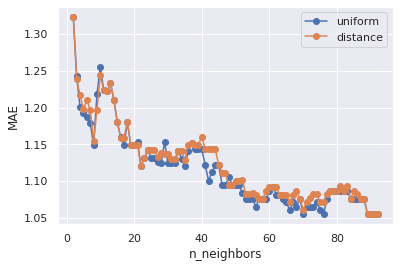

In [99]:
max_n_neighbors = int(0.1 * len(X))
for weights in ['uniform', 'distance']:
    knn = neighbors.KNeighborsRegressor(weights=weights)
    print(f"Weights: {weights} =>")
    generate_plot(X, y, knn, 'n_neighbors', range(2,max_n_neighbors), 10)
plt.show()  

### 1.1.2 Predictions

#### Model creation

In [100]:
n_neighbors = 70
weights = 'uniform'
knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights) 

print('MAE: ', fit_regressor(knn, X_train, y_train))

MAE:  0.7568573208586322


In [101]:
y_pred = LogShift.original(get_predictions(knn, X_test))

### 1.1.3 Visualisation

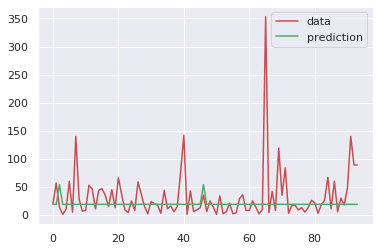

24.393617021276597

In [102]:
generate_visualization(y_pred, LogShift.original(y_test))

## 1.2 Decision Tree

### 1.2.1 Mean absolute error

Min Value: 1.1563846756768001 (2)


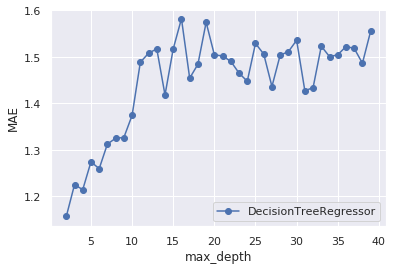

In [103]:
dt = DecisionTreeRegressor()
generate_plot(X, y, dt, 'max_depth', range(2,40), 10)
plt.show()

### 1.2.2 Predictions

In [104]:
dt = DecisionTreeRegressor(max_depth=2)
fit_regressor(dt, X_train, y_train)

0.7940888373989584

In [105]:
y_pred = LogShift.original(get_predictions(dt, X_test))

### 1.2.3 Visualisation

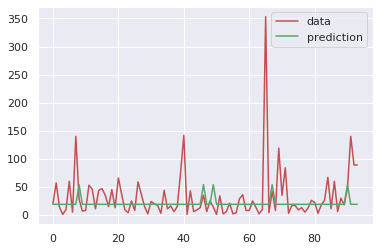

24.21276595744681

In [106]:
generate_visualization(y_pred, LogShift.original(y_test))

## 1.3 Random forest

### 1.3.1 Mean absolute error

Estimators: 2 =>
Min Value: 1.084099529917999 (2)
Estimators: 3 =>
Min Value: 1.0609603481870775 (2)
Estimators: 4 =>
Min Value: 1.0609603481870775 (2)
Estimators: 5 =>
Min Value: 1.0503220503147372 (2)
Estimators: 6 =>
Min Value: 1.0609603481870775 (2)
Estimators: 7 =>
Min Value: 1.0609603481870775 (2)


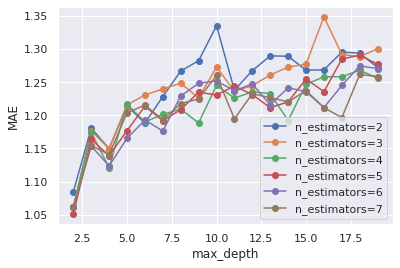

In [107]:
max_estimators = 8
max_max_depth = 20
for n in range(2, max_estimators):
    rf = RandomForestRegressor(n_estimators=n, criterion='mae', random_state=0)
    print(f"Estimators: {n} =>")
    generate_plot(X, y, rf, 'max_depth', range(2,max_max_depth), 10)
plt.show()

### 1.3.2 Predictions

In [108]:
rf = RandomForestRegressor(n_estimators=5, max_depth=2, criterion='mae', random_state=0)
fit_regressor(rf, X_train, y_train)

0.7479520934951693

In [109]:
y_pred = LogShift.original(get_predictions(rf, X_test))

### 1.3.3 Visualisation

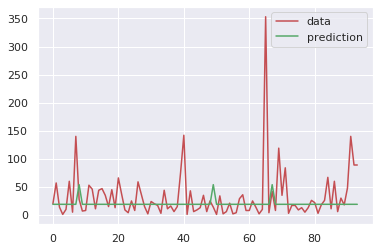

24.425531914893618

In [110]:
generate_visualization(y_pred, LogShift.original(y_test))

## 1.4 Linear SVR

### 1.4.1 Mean absolute error

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Lib

Min Value: 1.0922329715823114 (0.6429293697827494)


/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


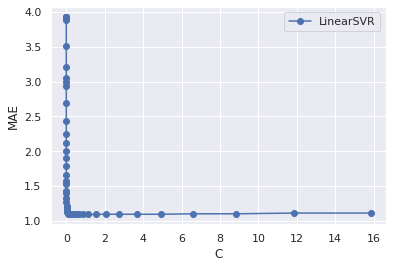

In [111]:
svr = svm.LinearSVR(C=1.0, epsilon=0.0, tol=1e-4, loss='squared_epsilon_insensitive', max_iter=1e4, random_state=99)
generate_plot(X, y, svr, 'C', np.logspace(-5,1.2,num=50), 10)
plt.show()

### 1.4.2 Predictions

In [112]:
svr = svm.LinearSVR(C=0.64, epsilon=0.0, loss='squared_epsilon_insensitive', max_iter=1e4, random_state=99)
fit_regressor(svr, X_train, y_train)

0.7904652493571906

In [113]:
y_pred = LogShift.original(get_predictions(svr, X_test))

### 1.4.3 Visualisation

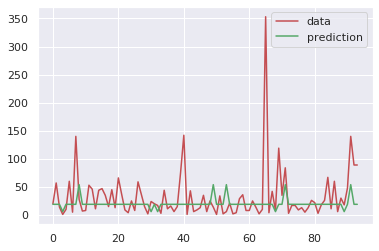

24.28723404255319

In [114]:
generate_visualization(y_pred, LogShift.original(y_test))

# 2. Automatic optimization

## Helper functions

In [115]:
def report(results, n_top=3): 
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

## 2.1 Boosting

In [116]:
regressor_names = ['KNN', 'Decision tree', 'Random Forest', 'Ada Boost', 'GradientBoosting']
regressors = [KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights),
              DecisionTreeRegressor(max_depth=3),
              RandomForestRegressor(n_estimators=4, max_depth=3, criterion='mae',random_state=0),
              AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.5),
              GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=0, loss='ls')]
regressors = {regressor_names[i]: regressors[i] for i in range(0,len(regressor_names))}

In [117]:
for i, reg in regressors.items():
    print(f'{i}:\n\tMAE:{get_accuracy(reg, X_train, y_train, 12)}')

KNN:
	MAE:0.8888014296463034
Decision tree:
	MAE:0.9044147049015961
Random Forest:
	MAE:0.8686669959803699
Ada Boost:
	MAE:0.8647552559210745
GradientBoosting:
	MAE:0.8792522982923968


In [118]:
regressors_df = pd.DataFrame({i:r.feature_importances_ for i,r in list(regressors.items())[1:]}, index=X_train.columns)

In [119]:
regressors_df.sum()

Decision tree       1.0
Random Forest       1.0
Ada Boost           1.0
GradientBoosting    1.0
dtype: float64

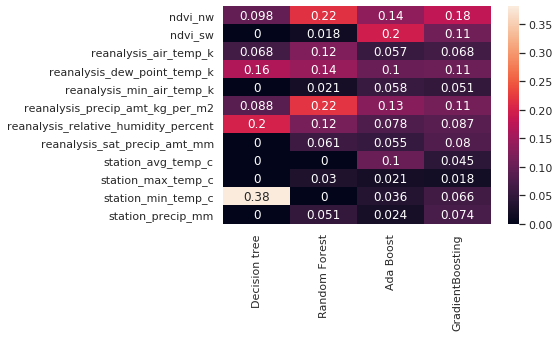

In [120]:
sns.heatmap(regressors_df, annot=True)

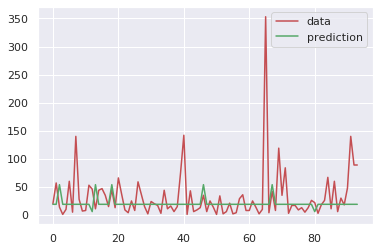

24.74468085106383

In [121]:
generate_visualization(LogShift.original(get_predictions(regressors['Ada Boost'], X_test)), LogShift.original(y_test))

## 2.2 Grid Search

### 2.2.1 Setting

In [122]:
param_dist = {"n_estimators": [2, 4, 8, 16, 32, 64], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": np.arange(2,16,2), # Maximum number of levels in tree
              "min_samples_split": np.arange(2,10,2), #  Minimum number of samples required to split a node
              "min_samples_leaf": np.arange(8,16,2), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False] # Method of selecting samples for training each tree
            }

In [123]:
est_rf = RandomForestRegressor()
grid_regres = GridSearchCV(estimator=est_rf, param_grid=param_dist, cv=5)

grid_regres.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': array([ 8, 10, 12, 14]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': [2, 4, 8, 16, 32, 64]})

### 2.2.2 Results

In [124]:
report(grid_regres.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.131 (std: 0.046)
Parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.123 (std: 0.038)
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 64}

Model with rank: 3
Mean validation score: 0.121 (std: 0.027)
Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 16}

Model with rank: 4
Mean validation score: 0.121 (std: 0.041)
Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 32}

Model with rank: 5
Mean validation score: 0.121 (std: 0.036)
Parameters: {'bootstrap': True, 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimator

In [125]:
grid_regres.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 32}

In [126]:
get_mae(grid_regres.best_estimator_, X_test, y_test)

0.9513455165703378

### 2.2.3 Visualisation

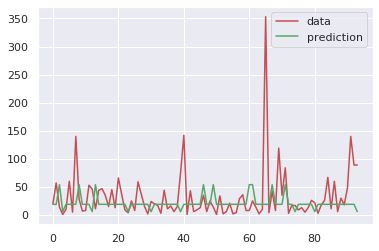

25.95744680851064

In [127]:
generate_visualization(LogShift.original(get_predictions(grid_regres.best_estimator_, X_test)), LogShift.original(y_test))

## 2.3 Randomized Search

### 2.3.1 Setting

In [128]:
param_dist = {"n_estimators": sp_randint(2,256), # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [16, 12, 8, 4, 2, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["mse", "mae"]}

In [129]:
rnd_regres = RandomizedSearchCV(estimator=est_rf, param_distributions=param_dist, 
                               n_iter=1000, cv=5, random_state=0, n_jobs=-1)
rnd_regres.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [16, 12, 8, 4, 2, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f20499b4af0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2049990f40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f20499909d0>},
                   random_state=0)

### 2.3.2 Results

In [130]:
report(rnd_regres.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.137 (std: 0.029)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 98}

Model with rank: 2
Mean validation score: 0.124 (std: 0.046)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 89}

Model with rank: 3
Mean validation score: 0.123 (std: 0.031)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 103}

Model with rank: 4
Mean validation score: 0.122 (std: 0.039)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 83}

Model with rank: 5
Mean validation score: 0.121 (std: 0.042)
Parameters: {'bootstrap': True, 'criterion': '

In [131]:
rnd_regres.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 98}

In [132]:
get_mae(rnd_regres.best_estimator_, X_test, y_test)

0.9080035102995788

### 2.3.3 Visualisation

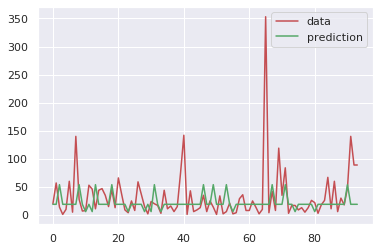

25.180851063829788

In [133]:
generate_visualization(LogShift.original(get_predictions(rnd_regres.best_estimator_, X_test)), LogShift.original(y_test))

## 2.4 Collected models comparison
Compare performance on the unsplitted dataset.

In [164]:
collected = [knn, dt, rf, svr, grid_regres.best_estimator_, rnd_regres.best_estimator_]
collected += [regressors[r] for r in regressor_names[-2:]]

In [167]:
scores = pd.DataFrame({str(r).replace('\n',''): get_mae(r, X, y) for r in collected}, index=['MAE']).T

In [168]:
scores.sort_values(by='MAE')

,MAE
RandomForestRegressor(n_estimators=98),0.417998
"GradientBoostingRegressor(n_estimators=200, random_state=0)",0.528316
"RandomForestRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=32)",0.709157
"AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), learning_rate=0.5, n_estimators=100)",0.772766
"LinearSVR(C=0.64, loss='squared_epsilon_insensitive', max_iter=10000.0, random_state=99)",0.798367
DecisionTreeRegressor(max_depth=2),0.798530
"RandomForestRegressor(criterion='mae', max_depth=2, n_estimators=5, random_state=0)",0.802001
KNeighborsRegressor(n_neighbors=70),0.811184


In [173]:
collected[-3]

RandomForestRegressor(n_estimators=98)

# 3. Submission
Run prediction with best estimator and create submittable result for datadriven competition.

### Select best regressor for submission

In [174]:
best_regressor_sj = collected[-3]

In [82]:
best_regressor_iq = rf

### Load test

In [86]:
test = preprocess(pd.read_csv('dengue_features_test.csv'))

In [87]:
test['total_cases'] = np.zeros(len(test))

In [88]:
test.drop(needs_cleaning + drop_features, axis=1, inplace=True)

### Run San Juan regressor

> PerformanceWarning caused by unsorted index

In [178]:
test.loc['sj','total_cases'] = LogShift.original(get_predictions(best_regressor_sj, test.drop('total_cases', axis=1).loc['sj']))

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2857: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


### Run Iquitos regressor

> PerformanceWarning caused by unsorted index

In [91]:
test.loc['iq','total_cases'] = LogShift.original(get_predictions(best_regressor_iq, test.loc['iq'].drop('total_cases', axis=1)))

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2857: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


### Create submission file

In [179]:
test

ndvi_nw   ndvi_sw  reanalysis_air_temp_k  \
city year weekofyear                                              
sj   2008 18         -1.021792 -1.203512              -0.220110   
          19         -0.975896 -1.409221              -0.231811   
          20         -1.028618 -1.199933               0.437065   
          21         -1.028618 -0.827883               0.596972   
          22         -0.607077 -1.370008               0.658399   
...                        ...       ...                    ...   
iq   2013 22          1.795033  1.976883              -0.710554   
          23          1.204130  1.619304              -1.124945   
          24          0.884167  0.523695              -2.036606   
          25          1.249018  2.202977              -2.072682   
          26          0.806799  0.783243              -0.984540   

                      reanalysis_dew_point_temp_k  reanalysis_min_air_temp_k  \
city year weekofyear                                                           
sj   2008 18                            -0.580271                   0.239043   
          19                            -0.666536                   0.348040   
          20                            -0.067370                   0.239043   
          21                            -0.661848                   0.420705   
          22                            -0.427432                   0.566034   
...                                           ...                        ...   
iq   2013 22                             0.149230                  -1.105256   
          23                             0.285191                  -1.504912   
          24                            -0.339292                  -1.831903   
          25                            -1.156934                  -1.177920   
          26                            -0.522136                  -2.231560   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   2008 18                                -0.341286   
          19                                -0.413850   
          20                                -0.776877   
          21                                -0.816234   
          22                                -0.771958   
...                                               ...   
iq   2013 22                                 0.524362   
          23                                 0.075447   
          24                                 0.065608   
          25                                -0.764988   
          26                                -0.291475   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   2008 18                                     -0.501039   
          19                                     -0.575909   
          20                                     -0.570478   
          21                                     -1.283880   
          22                                     -1.138795   
...                                                    ...   
iq   2013 22                                      1.020808   
          23                                      1.550526   
          24                                      1.696581   
          25                                      0.894149   
          26                                      0.618913   

                      reanalysis_sat_precip_amt_mm  station_avg_temp_c  \
city year weekofyear                                                     
sj   2008 18                              1.150400           -0.675916   
          19                             -0.728707           -1.049736   
          20                             -0.981948            0.468905   
          21                             -1.086090            0.574042   
          22                             -1.064465            0.211904   
...                                        

In [180]:
save_results(test.loc[:,'total_cases'].values, 'submission.csv', test.index)

'submission.csv'